# Title

## 1. Introduction

TBA

## 2. Preliminary Results

### 2.1 R Preamble

In [1]:
# Run this first.
library(tidyverse)
library(tidymodels)

set.seed(5)
options(repr.plot.width = 6, repr.plot.height = 6)

SRC <-
    c("https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/ubc.csv",
      "https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/sfu.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 2.2 Loading and wrangling the dataset

Note that the raw UBC and SFU datasets span different date ranges. However, our analysis will focus mainly on the min. and max. temperature, which might vary depending on the date. To prevent this from potentially skewing our results, we filter our wrangled dataset such that it spans the intersection of the UBC and SFU date ranges (from January 1 to June 30, 1995).

In [8]:
# Load and label the raw datasets for UBC and SFU, respectively.
ubc_raw <- read_csv(SRC[1], show_col_types = FALSE) |>
    mutate(location = as.factor("UBC"))

sfu_raw <- read_csv(SRC[2], show_col_types = FALSE) |>
    mutate(location = as.factor("SFU"))

# Join the datasets, select the relevant variables, and tidy the data.
ubc_sfu_raw <- bind_rows(ubc_raw, sfu_raw) |>
    rename(date_time = "Date/Time", min_temp_c = "Min Temp (°C)", max_temp_c = "Max Temp (°C)") |>
    select(location, date_time, min_temp_c, max_temp_c) |>
    filter(!is.na(min_temp_c), !is.na(max_temp_c))

# Find the intersection of the date ranges and filter the dataset.
date_range <- ubc_sfu_raw |>
    group_by(location) |>
    summarize(min = min(date_time), max = max(date_time)) |>
    ungroup() |>
    summarize(min = max(min), max = min(max))

ubc_sfu_data <- ubc_sfu_raw |>
    filter(between(date_time, date_range$min, date_range$max))

# Preview the dataset.
cat("\n\nTable 1: Cleaned and Filtered Combined Data for UBC and SFU")
head(ubc_sfu_data)
tail(ubc_sfu_data)



Table 1: Cleaned and Filtered Combined Data for UBC and SFU

location,date_time,min_temp_c,max_temp_c
<fct>,<date>,<dbl>,<dbl>
UBC,1995-01-01,-3.5,4.0
UBC,1995-01-02,-3.5,4.0
UBC,1995-01-03,-4.5,4.5
UBC,1995-01-04,-5.0,4.0
UBC,1995-01-05,-4.0,3.0
UBC,1995-01-06,-4.0,3.0


location,date_time,min_temp_c,max_temp_c
<fct>,<date>,<dbl>,<dbl>
SFU,1995-06-25,12,24.0
SFU,1995-06-26,12,22.0
SFU,1995-06-27,16,25.0
SFU,1995-06-28,19,29.0
SFU,1995-06-29,20,29.5
SFU,1995-06-30,21,30.0


### 2.3 Summary statistics

We calculate the summary statistics of interest for both UBC and SFU. We can see that the sample sizes are not equal, but this is not a problem since both asymptotics and bootstrap methods will address this.

In [9]:
ubc_sfu_summary <- ubc_sfu_data |>
    group_by(location) |>
    summarize(mean_min = mean(min_temp_c),
              sd_min = sd(min_temp_c),
              mean_max = mean(max_temp_c),
              sd_max = sd(max_temp_c),
              n = n())

cat("\n\nTable 2: Summary Statistics for UBC and SFU")
ubc_sfu_summary



Table 2: Summary Statistics for UBC and SFU

location,mean_min,sd_min,mean_max,sd_max,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
UBC,6.279006,4.821630,13.10773,5.523258,181
SFU,5.770950,4.812559,13.11732,6.357132,179


### 2.4 Preliminary visualization

We begin by plotting the raw data in order to better understand the dataset. Roughly speaking, it appears that the minimum and maximum temperatures for both locations are correlated as they follow a similar trend over time.

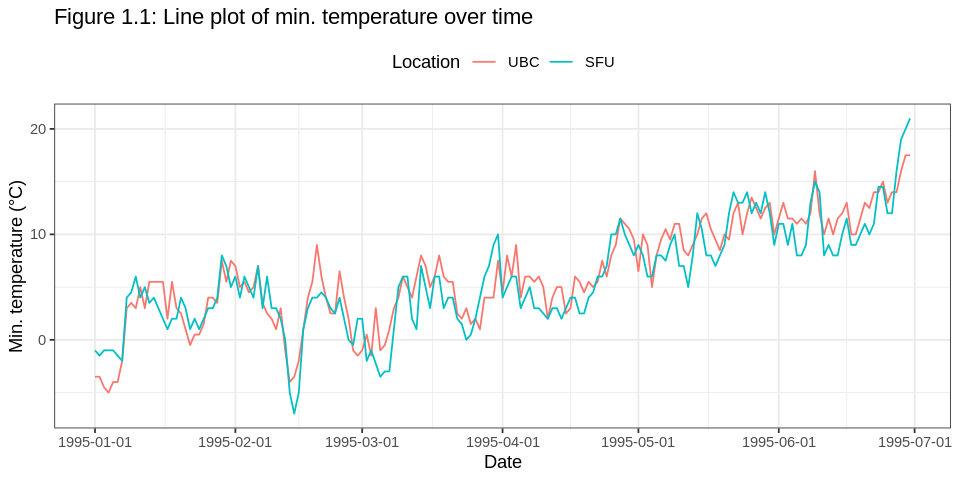

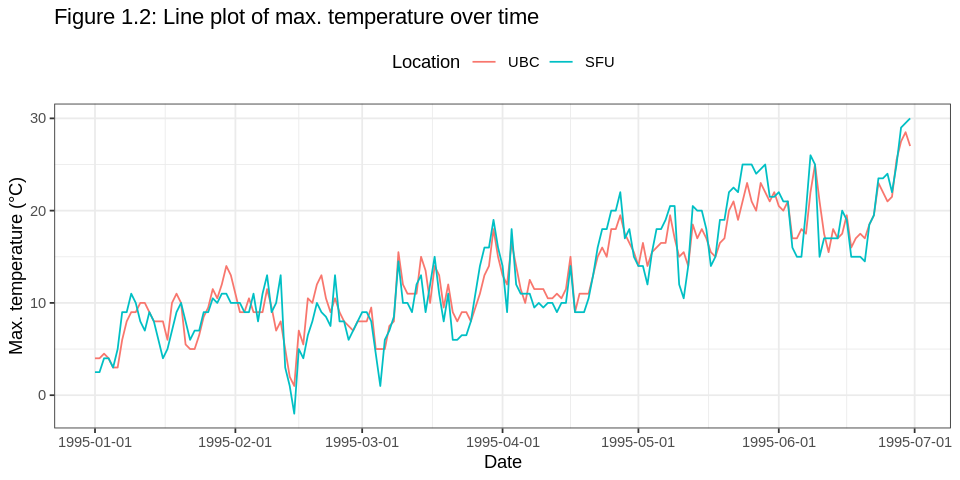

In [10]:
# Line plot for minimum temperatures
ubc_sfu_min_line_plot <- ubc_sfu_data |>
    ggplot(aes(x = date_time, y = min_temp_c, color = location)) +
        geom_line(alpha = 1) +
        labs(title = "Figure 1.1: Line plot of min. temperature over time",
             x = "Date", y = "Min. temperature (°C)", color = "Location") +
        scale_x_date(breaks = "1 month") +
        theme_bw() +
        theme(legend.position = "top")

# Line plot for maximum temperatures
ubc_sfu_max_line_plot <- ubc_sfu_data |>
    ggplot(aes(x = date_time, y = max_temp_c, color = location)) +
        geom_line(alpha = 1) +
        labs(title = "Figure 1.2: Line plot of max. temperature over time",
             x = "Date", y = "Max. temperature (°C)", color = "Location") +
        scale_x_date(breaks = "1 month") +
        theme_bw() +
        theme(legend.position = "top")

ubc_sfu_min_line_plot
ubc_sfu_max_line_plot

We can also plot and compare the sample distributions for both locations, which suggests that the population distribution of min. and max. temperature might not be normal—in particular, the distributions for UBC seems somewhat bimodal. Nonetheless, our sample sizes of 179 and 181 are still large enough for the Central Limit Theorem to apply.

The spread of the minimum and maximum temperature for both locations appears to be quite similar, which also aligns with our computed summary statistics.

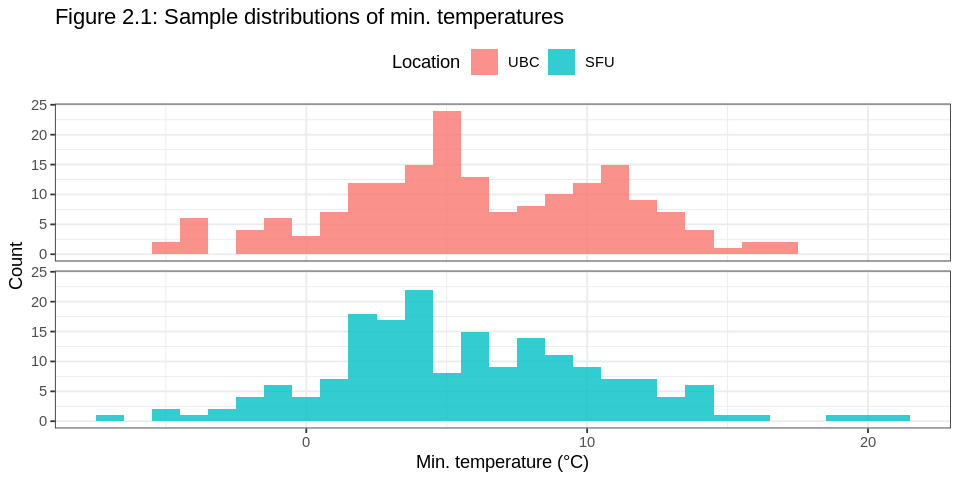

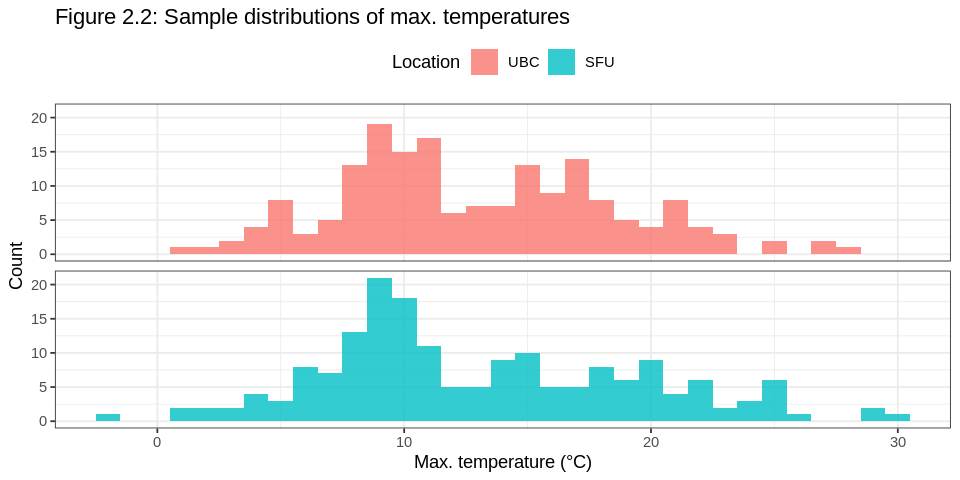

In [11]:
ubc_sfu_min_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = min_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 2.1: Sample distributions of min. temperatures",
             x = "Min. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

ubc_sfu_max_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = max_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 2.2: Sample distributions of max. temperatures",
             x = "Max. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

ubc_sfu_min_sample_dist
ubc_sfu_max_sample_dist

To get a better idea of the centers and spreads of the distributions, we can look at boxplots. We see that both sample distributions for minimum and maximum temperatures (especially SFU's maximum temperature) are slightly right-skewed and that the sample distribution for SFU's minimum daily temperatures appear shifted to the left from UBC with a similar spread, which aligns with the summary statistics.

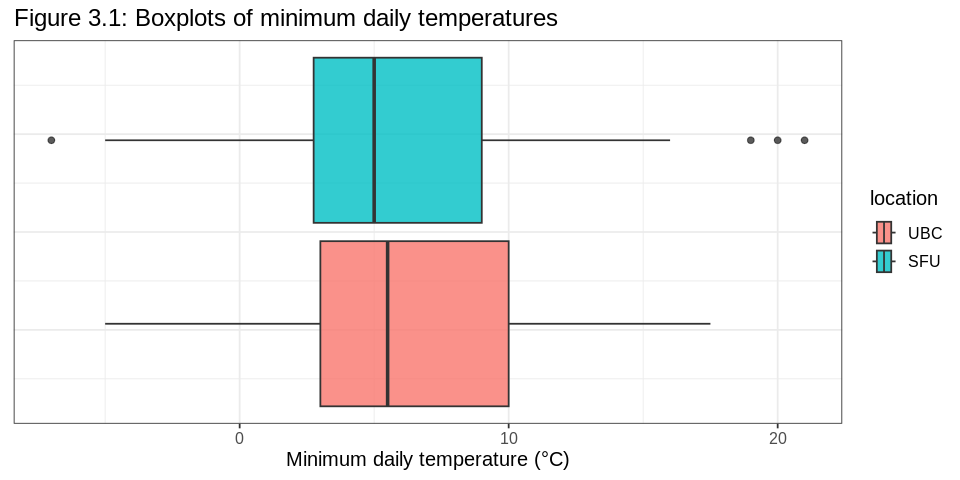

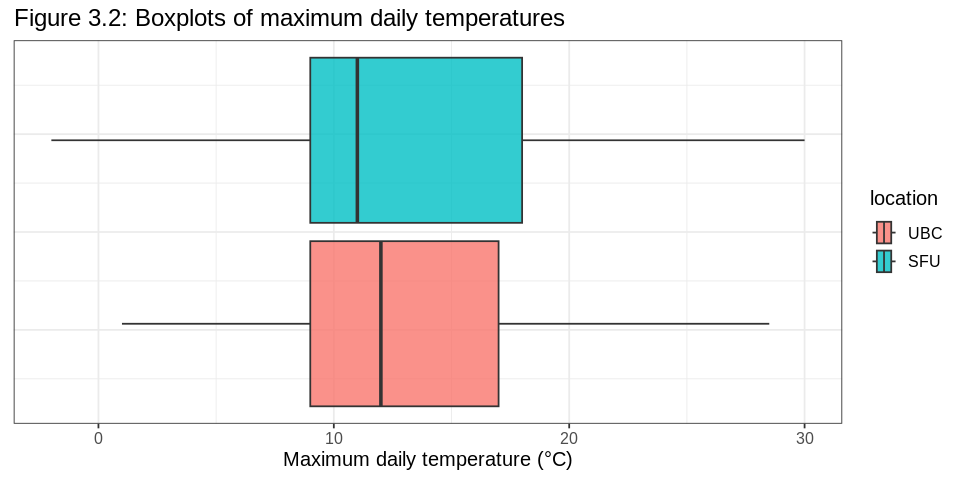

In [15]:
options(repr.plot.width = 8, repr.plot.height = 4)

# Boxplot for minimum daily temperature
ubc_sfu_min_boxplot <- ubc_sfu_data %>%
    ggplot(aes(x = min_temp_c, fill = location)) +
    geom_boxplot(alpha = 0.8) + 
    xlab("Minimum daily temperature (°C)") +
    theme_bw() +
    theme(text = element_text(size = 12), axis.text.y = element_blank(), axis.ticks.y = element_blank()) +
    ggtitle("Figure 3.1: Boxplots of minimum daily temperatures")

# Boxplot for maximum daily temperature
ubc_sfu_max_boxplot <- ubc_sfu_data %>%
    ggplot(aes(x = max_temp_c, fill = location)) +
    geom_boxplot(alpha = 0.8) + 
    xlab("Maximum daily temperature (°C)") +
    theme_bw() +
    theme(text = element_text(size = 12), axis.text.y = element_blank(), axis.ticks.y = element_blank()) +
    ggtitle("Figure 3.2: Boxplots of maximum daily temperatures")

ubc_sfu_min_boxplot
ubc_sfu_max_boxplot